In [1]:
from comet_ml import Experiment

import os

CUDA_NUM = 1
os.environ["CUDA_VISIBLE_DEVICES"]=str(CUDA_NUM)



In [2]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm as tqdm_notebook
from tqdm import tqdm as tqdm
import itertools

import seaborn as sns
from IPython.display import clear_output

%matplotlib inline


In [3]:
MODEL_NAME = "boosting_play"

BATCH_SIZE = int(64)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

NUM_LAYERS = 15

In [4]:
import logging

os.makedirs('log', exist_ok=True)
logging.basicConfig(filename=f'log/{MODEL_NAME}.log',
                    filemode='w',
                    format='%(asctime)s, %(funcName)s - %(levelname)s - %(message)s',
                    datefmt='%d-%b %H:%M:%S',
                    level=logging.DEBUG)
logger = logging.getLogger('main')
logging.info(f"Logging started. " +
             f"MODEL_NAME:{MODEL_NAME}, BATCH_SIZE:{BATCH_SIZE}, NUM_LAYERS:{NUM_LAYERS} " +
             f"device:{device}, CUDA_NUM:{CUDA_NUM}")


## Data

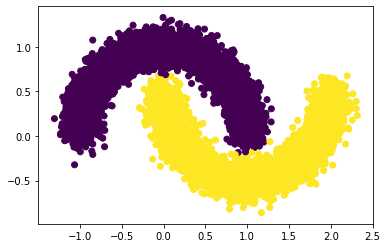

In [5]:
from sklearn.datasets import make_moons

moons_x, moons_y = make_moons(10000, shuffle=True, noise=0.1)
plt.scatter(moons_x[:, 0], moons_x[:, 1], c=moons_y)
plt.show()

In [6]:
moon_dataloader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(torch.Tensor(moons_x)),
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)

get_dataloader = lambda x: torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(data),
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True
)



In [7]:
from torch import distributions
from torch.distributions import MultivariateNormal, Uniform, TransformedDistribution, SigmoidTransform
from torch.nn.parameter import Parameter

from nflib.flows import (
    AffineConstantFlow, ActNorm, AffineHalfFlow, MAF, IAF, Invertible1x1Conv,
    NormalizingFlow, NormalizingFlowModel, RandomPerm
)
from nflib.spline_flows import NSF_AR, NSF_CL
from nflib.nets import ARMLP, ResidualNet


## Model

In [8]:
class NormalizingFlow(nn.Module):
    """ A sequence of Normalizing Flows is a Normalizing Flow """

    def __init__(self, flows):
        super().__init__()
        self.register_buffer('placeholder', torch.randn(1))
        self.flows = nn.ModuleList(flows)

    def forward(self, x, index, context=None):
        m, _ = x.shape
        log_det = torch.zeros(m, device=self.placeholder.device)
        zs = [x]
        for flow in self.flows[:index]:
            x, ld = flow.forward(x, context=context)
            log_det += ld
            zs.append(x)
        return zs, log_det

    def backward(self, z, context=None):
        m, _ = z.shape
        log_det = torch.zeros(m, device=self.placeholder.device)
        xs = [z]
        for flow in self.flows[::-1]:
            z, ld = flow.backward(z, context=context)
            log_det += ld
            xs.append(z)
        return xs, log_det

class NormalizingFlowModel(nn.Module):
    """ A Normalizing Flow Model is a (prior, flow) pair """
    
    def __init__(self, prior, flows, num_per_block):
        super().__init__()
        self.register_buffer('placeholder', torch.randn(1))
        self.prior = prior
        self.flow = NormalizingFlow(flows)
        self.num_per_block = num_per_block
    
    def forward(self, x, index, context=None):
        zs, log_det = self.flow.forward(x, (index + 1) * self.num_per_block, context=context)
        prior_logprob = self.prior.log_prob(zs[-1]).view(x.shape[0], -1).sum(1).to(self.placeholder.device)
        return zs, prior_logprob, log_det

    def backward(self, z, context=None):
        xs, log_det = self.flow.backward(z, context=context)
        return xs, log_det
    
    def sample(self, num_samples, context=None):
        z = self.prior.sample((num_samples,)).to(self.placeholder.device)
        xs, _ = self.backward(z, context=context)
        return xs


In [9]:
dim = 2
num_per_block = 2

prior = MultivariateNormal(torch.zeros(dim).to(device), torch.eye(dim).to(device))

flows = []
for i in range(NUM_LAYERS):
    flows.append(
        MAF(dim=dim, parity=True,
               hidden_dim=16,
               context=False)
    )
    flows.append(
        ActNorm(dim=dim)
    )
    
model = NormalizingFlowModel(prior, flows, num_per_block=num_per_block).to(device)

logger.info(f'Model assembled, {model}')

# optimizer
LR = 1e-3

def get_optim(index, num_per_block=num_per_block):
    return torch.optim.Adam(model.flow.flows[index * num_per_block: num_per_block * (index + 1)].parameters(), lr=LR)

logger.info(f"number of params: {sum(p.numel() for p in model.parameters())}")


In [10]:
dataloader = moon_dataloader

x = next(iter(dataloader))[0].to(device)
zs, prior_logprob, log_det = model(x, 0)

In [11]:
x = next(iter(dataloader))[0].to(device)
# samples = model.sample(1000)

## Train

In [12]:
EPOCHS_PER_MODEL = int(30)

In [13]:
experiment = Experiment(api_key="HIZapbzNjFips0c32Co7gXkQZ",
                        project_name="rich2019", workspace="maximartemev", disabled=False)
logger.info(f"Experiment is live on comet.ml, {experiment.focus_link + experiment.id}")

COMET INFO: old comet version (3.0.2) detected. current: 3.1.0 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Failing to collect the installed os packages
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/maximartemev/rich2019/4a5fa0a5429d4728a61960541e824825



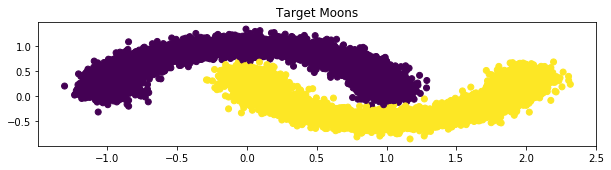

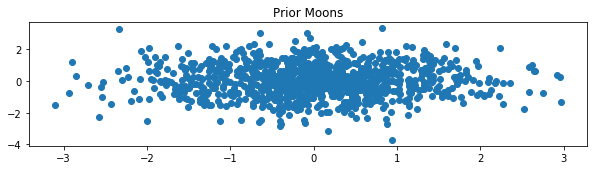

  0%|          | 0/15 [00:00<?, ?it/s]

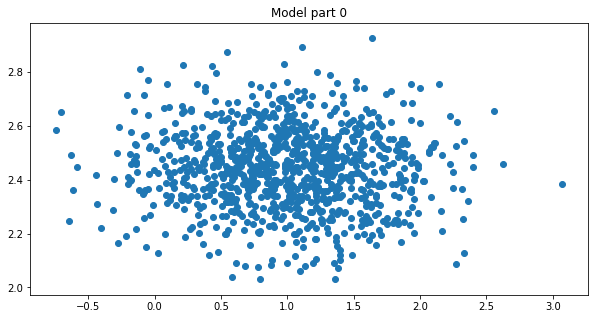

  7%|▋         | 1/15 [00:29<06:57, 29.85s/it]

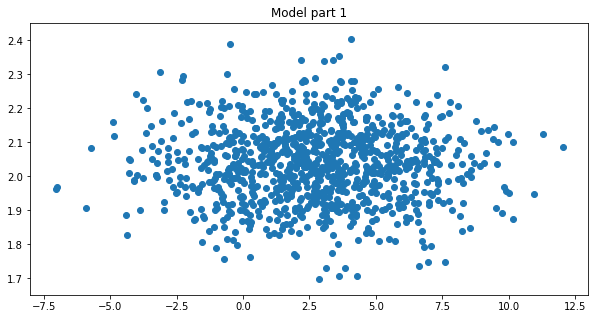

 13%|█▎        | 2/15 [01:08<07:01, 32.45s/it]

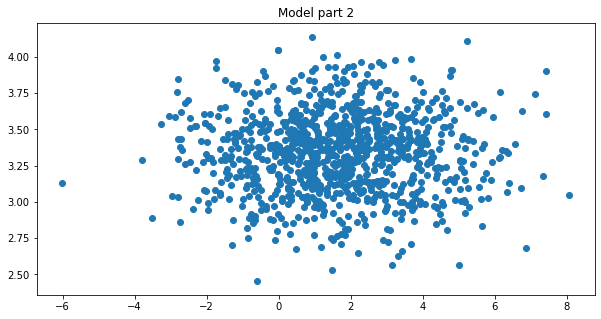

 20%|██        | 3/15 [01:55<07:21, 36.75s/it]

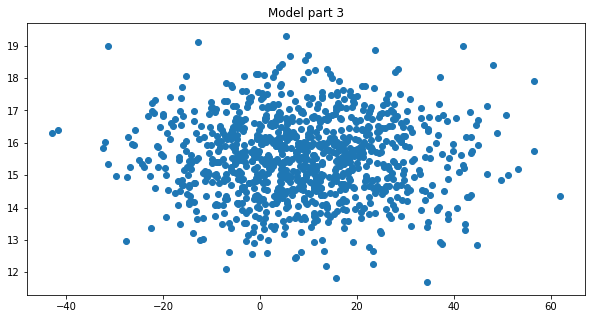

 27%|██▋       | 4/15 [02:50<07:46, 42.44s/it]

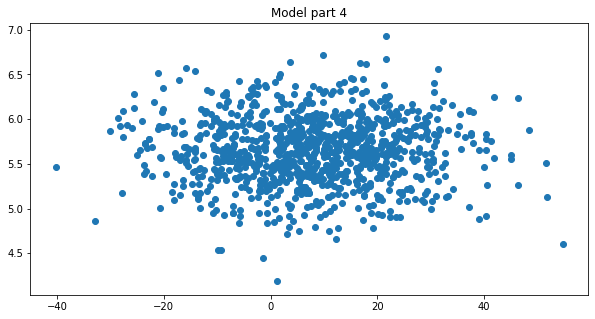

 33%|███▎      | 5/15 [03:54<08:07, 48.75s/it]

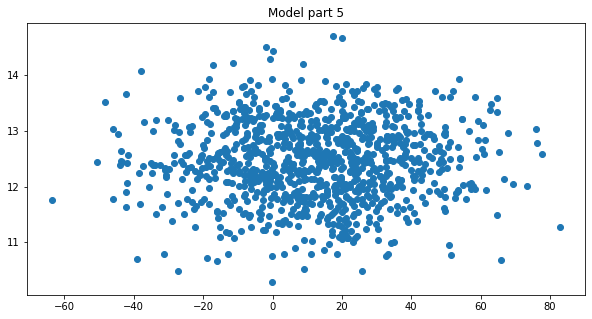

 40%|████      | 6/15 [05:06<08:21, 55.74s/it]

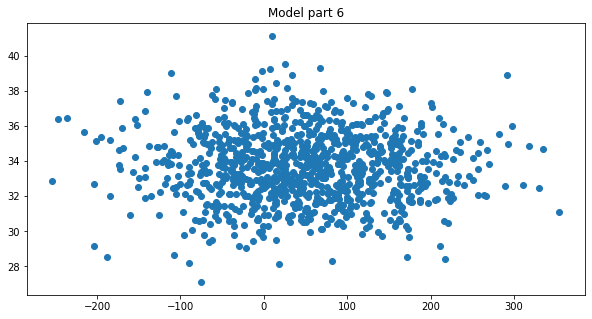

 47%|████▋     | 7/15 [06:27<08:27, 63.38s/it]

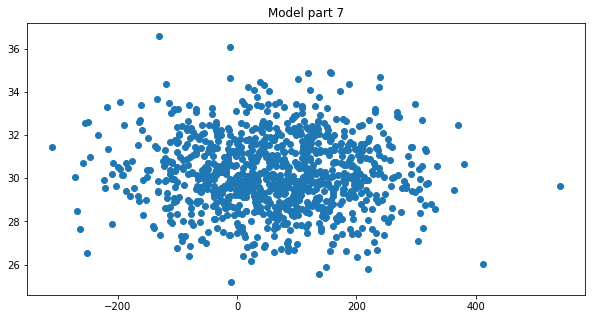

 53%|█████▎    | 8/15 [07:56<08:17, 71.10s/it]

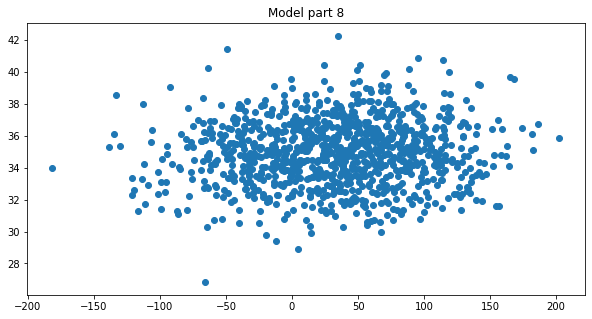

 60%|██████    | 9/15 [09:33<07:52, 78.80s/it]

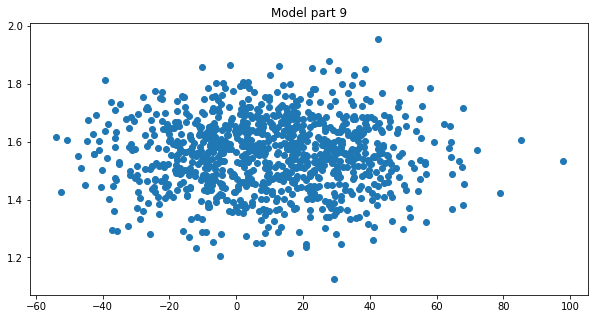

 67%|██████▋   | 10/15 [11:18<07:13, 86.74s/it]

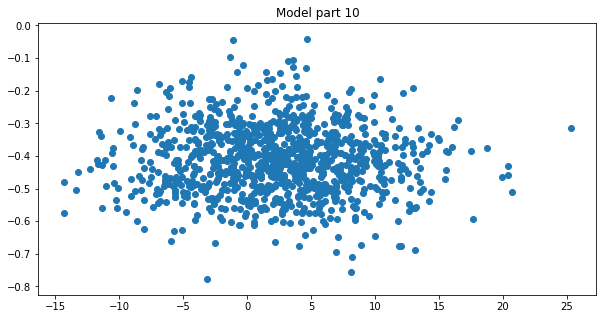

 73%|███████▎  | 11/15 [13:13<06:20, 95.04s/it]

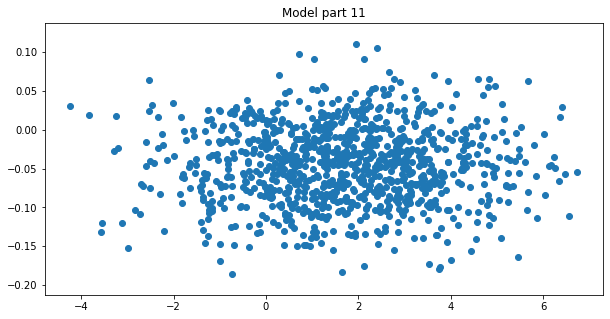

 80%|████████  | 12/15 [15:16<05:10, 103.65s/it]

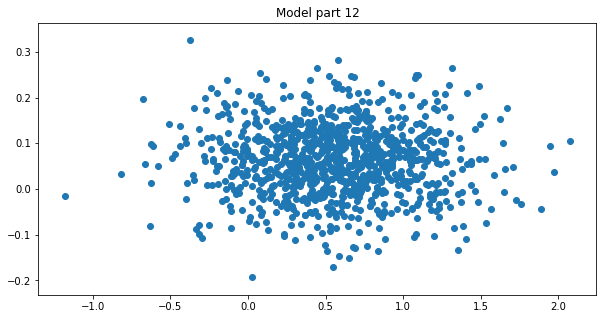

 87%|████████▋ | 13/15 [17:29<03:44, 112.27s/it]

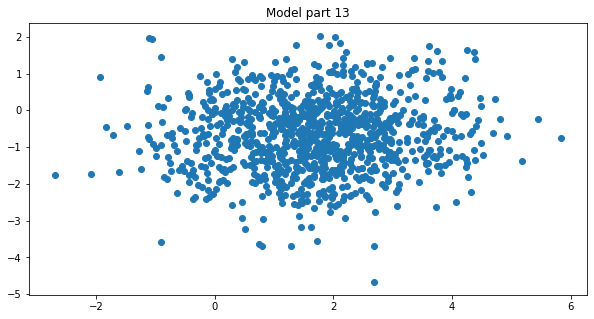

 93%|█████████▎| 14/15 [19:50<02:00, 120.81s/it]

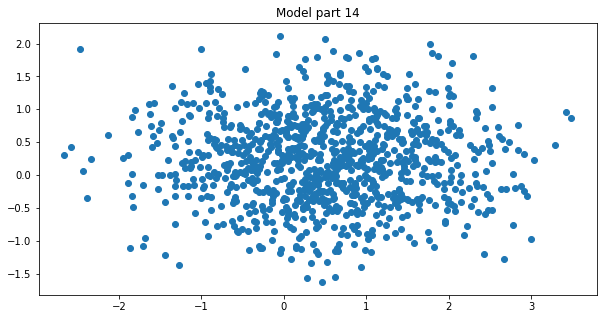

100%|██████████| 15/15 [22:19<00:00, 89.28s/it] 


In [14]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.title('Target Moons')
plt.scatter(moons_x[:, 0], moons_x[:, 1], c=moons_y)
experiment.log_figure('Target Moons')
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 2)
plt.title('Prior Moons')
prior_sample = prior.sample(torch.Size([1000])).cpu()
plt.scatter(prior_sample[:, 0], prior_sample[:, 1])
experiment.log_figure('Prior Moons')
plt.show()

for part_ind in tqdm(range(NUM_LAYERS), position=0, leave=True):
    optimizer = get_optim(part_ind)
    model.train()
    for epoch in tqdm_notebook(range(EPOCHS_PER_MODEL), leave=False):
        for batch_ind, batch in tqdm_notebook(enumerate(dataloader), total=len(dataloader), leave=False):
            step = epoch * len(dataloader) + batch_ind

            x = batch[0].to(device)
            zs, prior_logprob, log_det = model(x, part_ind)
            logprob = prior_logprob + log_det
            loss = -torch.sum(logprob)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            experiment.log_metric(f'model {part_ind} loss', loss.item(), step=step)
    model.eval()
    
    sampled = model.sample(1000)[-1].cpu().detach()
    plt.figure(figsize=(10, 5))
    plt.title(f'Model part {part_ind}')
    plt.scatter(sampled[:, 0], sampled[:, 1])
    experiment.log_figure(f'Model part {part_ind}')
    plt.show()

    

In [15]:
experiment.end()

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/maximartemev/rich2019/4a5fa0a5429d4728a61960541e824825
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [7020]                   : (93.62257385253906, 132.25137329101562)
COMET INFO:     model 0 loss [4680]           : (98.2275390625, 139.1722412109375)
COMET INFO:     model 1 loss [4680]           : (95.73895263671875, 125.22644805908203)
COMET INFO:     model 10 loss [4680]          : (93.26712036132812, 122.32334899902344)
COMET INFO:     model 11 loss [4680]          : (92.763671875, 120.16558837890625)
COMET INFO:     model 12 loss [4680]          : (93.17575073242188, 124.29954528808594)
COMET INFO:     model 13 loss [4680]          : (92.71542358398438, 123.30392456054688)
COMET INFO:     model 14 loss [4680]          : (93.80049133300781, 120.48387145996094)
COMET INFO:     model 2 loss [4680]           : (95.8466491699218

In [16]:
experiment = Experiment(api_key="HIZapbzNjFips0c32Co7gXkQZ",
                        project_name="rich2019", workspace="maximartemev", disabled=False)
logger.info(f"Experiment #2 is live on comet.ml, {experiment.focus_link + experiment.id}")


COMET INFO: old comet version (3.0.2) detected. current: 3.1.0 please update your comet lib with command: `pip install --no-cache-dir --upgrade comet_ml`
COMET WARNING: Failing to collect the installed os packages
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/maximartemev/rich2019/e17d1ad12f9e4b90bc75b6722ee83498



In [17]:
flows = []
for i in range(NUM_LAYERS):
    flows.append(
        MAF(dim=dim, parity=True,
               hidden_dim=16,
               context=False)
    )
    flows.append(
        ActNorm(dim=dim)
    )
    
model = NormalizingFlowModel(prior, flows, num_per_block=num_per_block).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

logger.info(f'Model assembled, {model}')

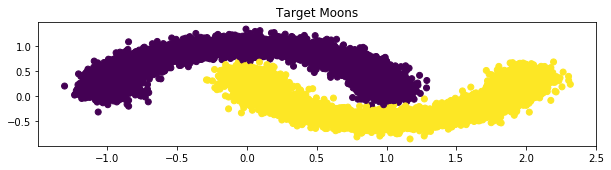

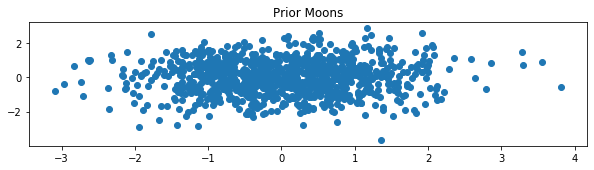

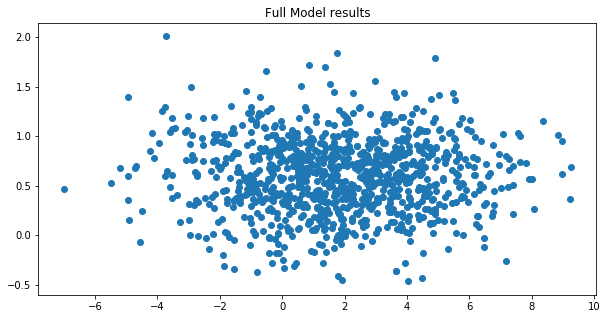

In [18]:
plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 1)
plt.title('Target Moons')
plt.scatter(moons_x[:, 0], moons_x[:, 1], c=moons_y)
experiment.log_figure('Target Moons')
plt.show()

plt.figure(figsize=(10, 5))
plt.subplot(2, 1, 2)
plt.title('Prior Moons')
prior_sample = prior.sample(torch.Size([1000])).cpu()
plt.scatter(prior_sample[:, 0], prior_sample[:, 1])
experiment.log_figure('Prior Moons')
plt.show()

model.train()
for epoch in tqdm_notebook(range(EPOCHS_PER_MODEL * 10), leave=False):
    for batch_ind, batch in tqdm_notebook(enumerate(dataloader), total=len(dataloader), leave=False):
        step = epoch * len(dataloader) + batch_ind

        x = batch[0].to(device)
        zs, prior_logprob, log_det = model(x, num_per_block*NUM_LAYERS + 1)
        logprob = prior_logprob + log_det
        loss = -torch.sum(logprob)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        experiment.log_metric(f' full model loss', loss.item(), step=step)
        
model.eval()
sampled = model.sample(1000)[-1].cpu().detach()

plt.figure(figsize=(10, 5))
plt.title(f'Full Model results')
plt.scatter(sampled[:, 0], sampled[:, 1])
experiment.log_figure(f'Full Model results')
plt.show()


In [19]:
experiment.end()

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/maximartemev/rich2019/e17d1ad12f9e4b90bc75b6722ee83498
COMET INFO:   Metrics [count] (min, max):
COMET INFO:      full model loss [46800]      : (44.66388702392578, 134.82339477539062)
COMET INFO:     loss [4680]                   : (44.66388702392578, 128.95445251464844)
COMET INFO:     sys.gpu.0.free_memory [44]    : (986382336.0, 986382336.0)
COMET INFO:     sys.gpu.0.gpu_utilization [44]: (0.0, 0.0)
COMET INFO:     sys.gpu.0.total_memory        : (11996954624.0, 11996954624.0)
COMET INFO:     sys.gpu.0.used_memory [44]    : (11010572288.0, 11010572288.0)
COMET INFO:     sys.gpu.1.free_memory [44]    : (11616976896.0, 11616976896.0)
COMET INFO:     sys.gpu.1.gpu_utilization [44]: (0.0, 31.0)
COMET INFO:     sys.gpu.1.total_memory        : (11996954624.0, 11996954624.0)
COMET INFO:     sys.gpu.1.used_memory [44]    : (379977728.0, 379977728.0

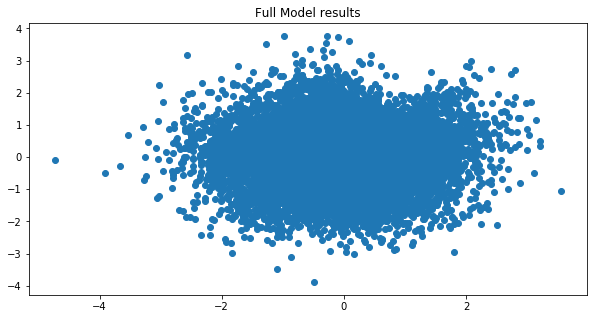

In [20]:
model.eval()
data = torch.cat([model(i[0].to(device), NUM_LAYERS)[0][-1] for i in dataloader], dim=0).cpu().detach()
plt.figure(figsize=(10, 5))
plt.title(f'Full Model results')
plt.scatter(data[:, 0], data[:, 1])
plt.show()


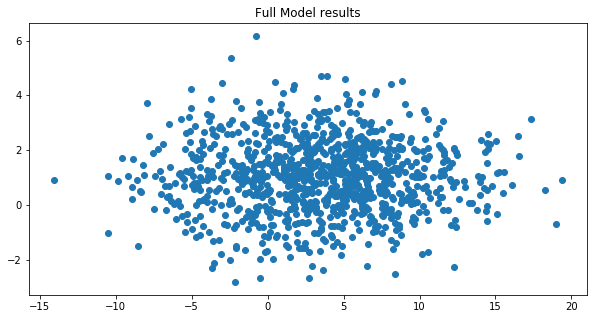

In [21]:
sampled = model.sample(1000)[NUM_LAYERS-1].cpu().detach()

plt.figure(figsize=(10, 5))
plt.title(f'Full Model results')
plt.scatter(sampled[:, 0], sampled[:, 1])
plt.show()
